### Pre-processing and Model Training ###

In [1]:
import tensorflow as tf
import zipfile
import numpy as np
import matplotlib.pylab as plt
import numpy as np
from google.colab import drive
from keras.preprocessing.image import ImageDataGenerator
from sklearn import preprocessing
from keras.callbacks import EarlyStopping, ModelCheckpoint
from model_utils import *
from define_models import *

In [4]:
drive.mount('/content/drive')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/final.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
train_path = "/tmp/final/train"
test_path = "/tmp/final/test"
val_path = "/tmp/final/val"

print("Training Size:")
print_dataset(train_path)

print("Test Size:")
print_dataset(test_path)

print("Validation Size:")
print_dataset(val_path)

Training Size:
Total number of frames: 25184

Category Normal: 8405 frames
Category Drowsy: 8335 frames
Category Distracted: 8444 frames

Test Size:
Total number of frames: 5396

Category Normal: 1801 frames
Category Drowsy: 1786 frames
Category Distracted: 1809 frames

Validation Size:
Total number of frames: 5400

Category Normal: 1802 frames
Category Drowsy: 1787 frames
Category Distracted: 1811 frames


In [5]:
image_size = (192,192)

train_x , train_y = load_dataset(train_path, image_size)
train_y = label_binarizer(train_y)

train_x = np.array(train_x)
train_y = np.array(train_y)
print(train_x.shape)
print(train_y.shape)

(25184, 192, 192, 3)
(25184, 3)


In [6]:
val_x , val_y = load_dataset(val_path, image_size)
val_y = label_binarizer(val_y)

val_x = np.array(val_x)
val_y = np.array(val_y)
print(val_x.shape)
print(val_y.shape)

(5396, 192, 192, 3)
(5396, 3)


In [7]:
test_x , test_y = load_dataset(test_path, image_size)
test_y = label_binarizer(test_y)

test_x = np.array(test_x)
test_y = np.array(test_y)
print(test_x.shape)
print(test_y.shape)

(5400, 192, 192, 3)
(5400, 3)


In [8]:
datagen = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
train_generator = datagen.flow(train_x, train_y, shuffle=True, batch_size=32)

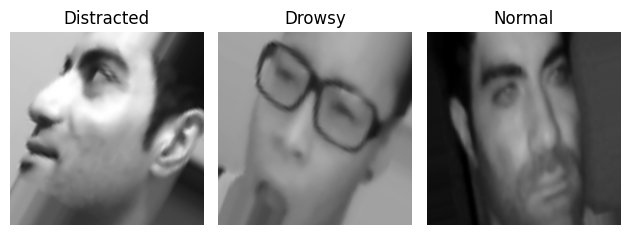

In [17]:
train_images,train_labels = train_generator.next()

fig, axs = plt.subplots(1, 3)

for j in range(3):
    axs[j].imshow(train_images[j])
    if train_labels[j][2] == 1:
      axs[j].set_title("Normal")
    elif train_labels[j][1] == 1:
      axs[j].set_title("Drowsy")
    else:
      axs[j].set_title("Distracted")
    axs[j].axis('off')

plt.tight_layout()
plt.show()


In [9]:
min_max_scaler = preprocessing.MinMaxScaler()

val_x = min_max_scaler.fit_transform(val_x.reshape(-1, val_x.shape[-1])).reshape(val_x.shape)
test_x = min_max_scaler.fit_transform(test_x.reshape(-1, test_x.shape[-1])).reshape(test_x.shape)

print(val_x.shape)
print(test_x.shape)

(5396, 192, 192, 3)
(5400, 192, 192, 3)


## MobileNetV3 Model ##

In [ ]:
model = define_mobilenet_model()
model.summary()

4334752/4334752 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['input_1[0][0]']             
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                                        
                                                                                                  
 tf.__operators__.add (TFOp  (N

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(amsgrad=True,name='Adam'), metrics=["accuracy"])
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/tmp/best_model_mobilenetv3.h5', save_best_only=True)

In [ ]:
history = model.fit(train_generator, epochs=100, batch_size=32, shuffle=True, validation_data=(val_x, val_y), callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
787/787 [==============================] - ETA: 0s - loss: 0.6025 - accuracy: 0.7341

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


787/787 [==============================] - 273s 330ms/step - loss: 0.6025 - accuracy: 0.7341 - val_loss: 0.4212 - val_accuracy: 0.8232
Epoch 2/100
787/787 [==============================] - 252s 320ms/step - loss: 0.4583 - accuracy: 0.7944 - val_loss: 0.3736 - val_accuracy: 0.8397
Epoch 3/100
787/787 [==============================] - 251s 319ms/step - loss: 0.4181 - accuracy: 0.8138 - val_loss: 0.3347 - val_accuracy: 0.8571
Epoch 4/100
787/787 [==============================] - 252s 321ms/step - loss: 0.3873 - accuracy: 0.8282 - val_loss: 0.3191 - val_accuracy: 0.8708
Epoch 5/100
787/787 [==============================] - 250s 317ms/step - loss: 0.3673 - accuracy: 0.8396 - val_loss: 0.3343 - val_accuracy: 0.8599
Epoch 6/100
787/787 [==============================] - 250s 318ms/step - loss: 0.3525 - accuracy: 0.8459 - val_loss: 0.3165 - val_accuracy: 0.8682
Epoch 7/100
787/787 [==============================] - 254s 323ms/step - loss: 0.3359 - accuracy: 0.8524 - val_loss: 0.2973 - val_

In [ ]:
model.save("/tmp/bestmodelmobilenetv3.keras")
np.save('/tmp/mobilenetv3.npy', history.history)

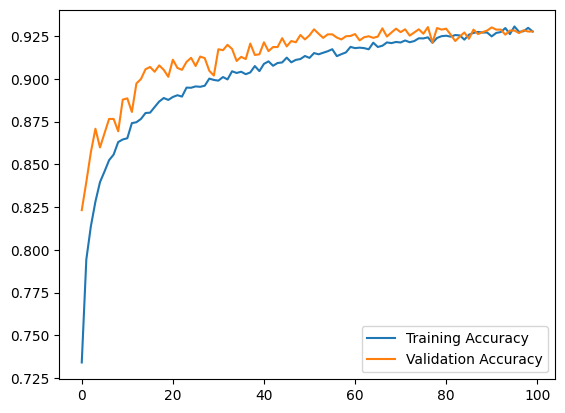

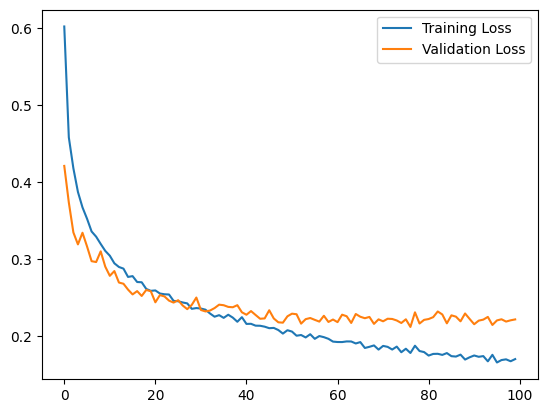

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(train_accuracy))

plt.plot(epochs, train_accuracy, label="Training Accuracy")
plt.plot(epochs, val_accuracy, label="Validation Accuracy")

plt.legend()
plt.show()

plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.legend()
plt.show()

In [21]:
test_loss, test_accuracy = model.evaluate(test_x, test_y, verbose=1)
print('MobileNet Model Accuracy - Test Dataset: ' , str(round(100*test_accuracy, 2))+"%")
print(f"MobileNet Model Loss - Test Dataset: {test_loss:.2f}")

169/169 [==============================] - 11s 16ms/step - loss: 0.1973 - accuracy: 0.9276
MobileNet Model Accuracy - Test Dataset:  92.76%
MobileNet Model Loss - Test Dataset: 0.20


## VGG 16 ##

In [ ]:
model = define_vgg16_model()
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0   

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(amsgrad=True, name='Adam'), metrics=["accuracy"])
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/tmp/best_model_vgg16.h5', save_best_only=True)

In [ ]:
history = model.fit(train_generator, epochs=100, batch_size=32, shuffle=True, validation_data=(val_x, val_y), callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
787/787 [==============================] - ETA: 0s - loss: 0.7262 - accuracy: 0.6821

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


787/787 [==============================] - 202s 253ms/step - loss: 0.7262 - accuracy: 0.6821 - val_loss: 0.4909 - val_accuracy: 0.7780
Epoch 2/100
787/787 [==============================] - 191s 242ms/step - loss: 0.5572 - accuracy: 0.7379 - val_loss: 0.4205 - val_accuracy: 0.8113
Epoch 3/100
787/787 [==============================] - 191s 242ms/step - loss: 0.5209 - accuracy: 0.7573 - val_loss: 0.3999 - val_accuracy: 0.8171
Epoch 4/100
787/787 [==============================] - 191s 242ms/step - loss: 0.4926 - accuracy: 0.7756 - val_loss: 0.3773 - val_accuracy: 0.8362
Epoch 5/100
787/787 [==============================] - 192s 244ms/step - loss: 0.4710 - accuracy: 0.7828 - val_loss: 0.3552 - val_accuracy: 0.8529
Epoch 6/100
787/787 [==============================] - 194s 246ms/step - loss: 0.4564 - accuracy: 0.7934 - val_loss: 0.3523 - val_accuracy: 0.8491
Epoch 7/100
787/787 [==============================] - 191s 242ms/step - loss: 0.4454 - accuracy: 0.8002 - val_loss: 0.3802 - val_

In [ ]:
model.save("/tmp/bestmodelvgg16.keras")
np.save('/tmp/vgg16.npy', history.history)

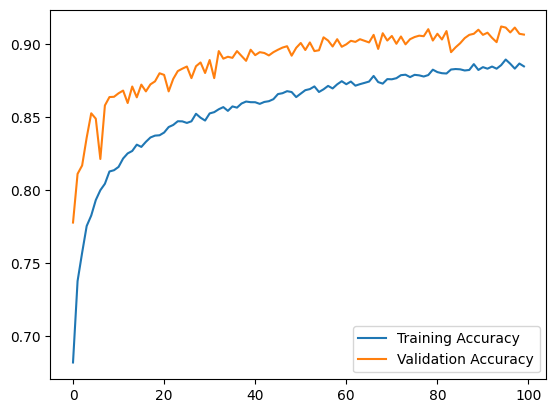

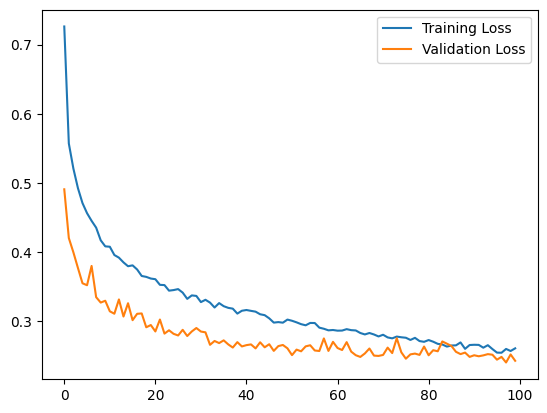

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(train_accuracy))

plt.plot(epochs, train_accuracy, label="Training Accuracy")
plt.plot(epochs, val_accuracy, label="Validation Accuracy")

plt.legend()
plt.show()

plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.legend()
plt.show()

In [24]:
test_loss, test_accuracy = model.evaluate(test_x, test_y, verbose=1)
print('VGG16 Model Accuracy - Test Dataset: ' , str(round(100*test_accuracy, 2))+"%")
print(f"VGG16 Model Loss - Test Dataset: {test_loss:.2f}")

169/169 [==============================] - 14s 36ms/step - loss: 0.2281 - accuracy: 0.9061
VGG16 Model Accuracy - Test Dataset:  90.61%
VGG16 Model Loss - Test Dataset: 0.23


## AlexNet Model ##

In [12]:
model = define_alexnet_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        11648     
                                                                 
 batch_normalization (Batch  (None, 46, 46, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 46, 46, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        247872    
                                                                 
 batch_normalization_1 (Bat  (None, 13, 13, 64)        2

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(amsgrad=True, name='Adam'), metrics=["accuracy"])
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/tmp/best_model_alexnet.h5', save_best_only=True)

In [25]:
history = model.fit(train_generator, epochs=100, batch_size=32, shuffle=True, validation_data=(val_x, val_y), callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
787/787 [==============================] - 197s 232ms/step - loss: 0.7959 - accuracy: 0.5864 - val_loss: 0.7040 - val_accuracy: 0.6431
Epoch 2/100
787/787 [==============================] - 174s 221ms/step - loss: 0.6385 - accuracy: 0.6709 - val_loss: 0.6085 - val_accuracy: 0.6987
Epoch 3/100
787/787 [==============================] - 173s 220ms/step - loss: 0.5953 - accuracy: 0.7038 - val_loss: 0.5450 - val_accuracy: 0.7330
Epoch 4/100
787/787 [==============================] - 173s 220ms/step - loss: 0.5528 - accuracy: 0.7323 - val_loss: 0.5443 - val_accuracy: 0.7537
Epoch 5/100
787/787 [==============================] - 173s 220ms/step - loss: 0.5202 - accuracy: 0.7584 - val_loss: 0.4324 - val_accuracy: 0.8023
Epoch 6/100
787/787 [==============================] - 173s 220ms/step - loss: 0.4848 - accuracy: 0.7815 - val_loss: 0.4686 - val_accuracy: 0.8036
Epoch 7/100
787/787 [==============================] - 178s 226ms/step - loss: 0.4597 - accuracy: 0.7961 - val_loss: 0

In [ ]:
model.save("/tmp/bestmodelalexnet.keras")
np.save('/tmp/alexnet.npy', history.history)

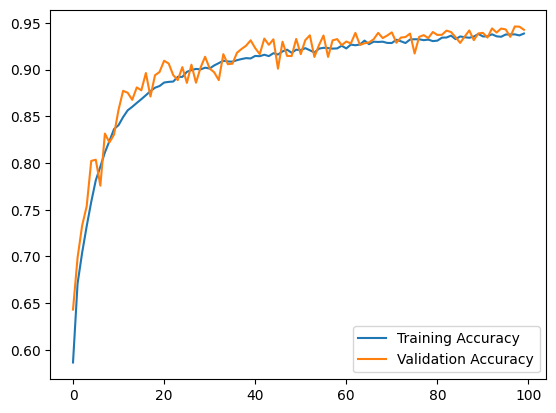

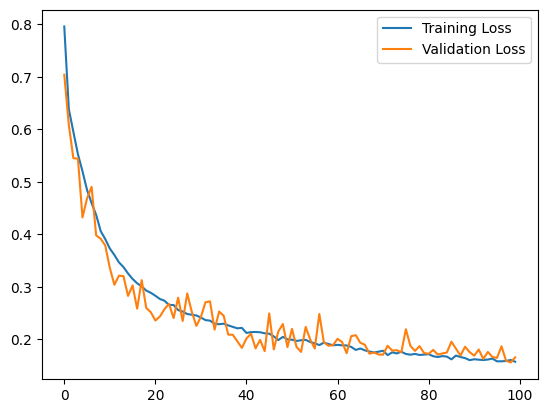

In [18]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(train_accuracy))

plt.plot(epochs, train_accuracy, label="Training Accuracy")
plt.plot(epochs, val_accuracy, label="Validation Accuracy")

plt.legend()
plt.show()

plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.legend()
plt.show()

In [22]:
test_loss, test_accuracy = model.evaluate(test_x, test_y, verbose=1)
print('AlexNet Model Accuracy - Test Dataset: ' , str(round(100*test_accuracy, 2))+"%")
print(f"AlexNet Model Loss - Test Dataset: {test_loss:.2f}")

169/169 [==============================] - 1s 8ms/step - loss: 0.1624 - accuracy: 0.9406
AlexNet Model Accuracy - Test Dataset:  94.06%
AlexNet Model Loss - Test Dataset: 0.16
